In [2]:
%%capture
import sys
import os
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
import faiss

### Loading the fashion-clip model

In [3]:
%%capture
fclip = FashionCLIP('fashion-clip')

### Data Preprocessing

In [3]:
articles = pd.read_csv("../../dataset/fashion-clip/articles.csv")

articles.shape[0]

105542

In [4]:
articles.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [5]:
root_dir = r"D:\CollegeWork\ShopLens-AR-Shopping-Assistant\dataset\fashion-clip\images"

image_names = []

for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith(('.jpg')):  # Filter by image extensions
            name_without_ext = os.path.splitext(file)[0][1:]
            image_names.append(name_without_ext)

image_names_array = np.array(image_names)

image_names_array.sort()

print(image_names_array)

['108775015' '108775044' '108775051' ... '956217002' '957375001'
 '959461001']


In [6]:
image_ids_set = set(image_names_array.astype(str))

articles = articles[articles['article_id'].astype(str).isin(image_ids_set)].copy()

articles.shape[0]


105100

In [7]:
# drop items that have the same description
subset = articles.drop_duplicates("detail_desc").copy()

# remove items of unkown category
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# FashionCLIP has a limit of 77 tokens, let's play it safe and drop things with more than 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# We also drop products types that do not occur very frequently in this subset of data
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

# subset = subset.head(3000).copy()

subset.shape[0]

37704

In [8]:
subset.to_csv("subset_data.csv", index=False)
f"{len(subset)} elements in the dataset"

'37704 elements in the dataset'

### Creating Image and Text Embeddings

In [9]:
images = ["../../dataset/fashion-clip/images/0" + str(k)[:2] + "/0" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# we create image embeddings and text embeddings
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

# we normalize the embeddings to unit norm (so that we can use dot product instead of cosine similarity to do comparisons)
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings/np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

1179it [49:59,  2.54s/it]                          


Map:   0%|          | 0/37704 [00:00<?, ? examples/s]

1179it [18:26,  1.07it/s]                          


### Saving Image and Text Embeddings

In [10]:
d = image_embeddings.shape[1]  # dimensionality

index = faiss.IndexFlatIP(d)
index.add(image_embeddings)

faiss.write_index(index, "faiss_image.index")

In [11]:
text_index = faiss.IndexFlatIP(text_embeddings.shape[1])
text_index.add(text_embeddings)
faiss.write_index(text_index, "faiss_text.index")


### Loading Image and Text Embeddings

In [4]:
image_index = faiss.read_index("faiss_image.index")
n_image_vectors = image_index.ntotal
image_embeddings = image_index.reconstruct_n(0, n_image_vectors)

text_index = faiss.read_index("faiss_text.index")
n_text_vectors = text_index.ntotal
text_embeddings = text_index.reconstruct_n(0, n_text_vectors)


subset = pd.read_csv("subset_data.csv")


### Search Engine

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 13.42it/s]


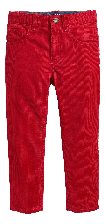

In [11]:
text_embedding = fclip.encode_text(["find me a pair of red jeans"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"../../dataset/fashion-clip/images/0{str(found_object)[:2]}/0{str(found_object)}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


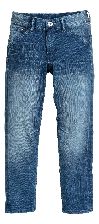

In [14]:
query_image = Image.open("output.png")
query_embedding = fclip.encode_images([query_image], batch_size=1)[0]
query_embedding = query_embedding / np.linalg.norm(query_embedding)
query_embedding = np.expand_dims(query_embedding, axis=0).astype(np.float32)

# Search: top 1 or top-k similar images
D, I = image_index.search(query_embedding, k=1)

matched_id = I[0][0]

matched_article_id = subset["article_id"].iloc[matched_id]

image = Image.open(f"../../dataset/fashion-clip/images/0{str(matched_article_id)[:2]}/0{str(matched_article_id)}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image